In [31]:
### CSC time plot


import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import  make_datacard_2sig, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [32]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'

ctau = '1000'
# masses = ['7', '15','40','55']

masses = ['40']

ntupler_version = 'V1p17/'
analyzer_version = "/v1/v167/"
decay = 'dddd'
ct = 1000

prod = ['ggH', 'VBFH','ZH', 'WH', 'ttH','ggZH']

ntupler_version = 'V1p17/'
mc_path = {}
analyzer_version = 'v1/v167/'
mc_central_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
analyzer_version = 'v2/v167/'
mc_private_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_Fall18/'+analyzer_version+'/normalized/'


for p in prod:
    for m in masses:
        key = 'MC_'+p + '_'+m+'_'+str(ct)
        if p == 'ggH':
            fpath[key] = mc_central_path+p+'_HToSSTodddd_MH-125_MS-'+m+'_ctau-'+str(ct)+'_137000pb_weighted.root'
        else:
            if 'ggH' in p or 'ttH' in p: fpath[key] = mc_private_path+p+'_HToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif p == 'VBFH' or p=='ZH' or p == 'WH': fpath[key] = mc_private_path+p+'ToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
            elif 'ggZH' in p:fpath[key] = mc_private_path+'ZHToSS_STodd_ms'+m+'_pl'+str(ct)+'_137000pb_weighted.root'
        if not os.path.exists(fpath[key]):print('FILE NOT FOUND',key, fpath[key])

                


analyzer_version = "/v5/v167/"
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path +'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print(k, "NEvents",NEvents[k])


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

MC_ggH_40_1000 NEvents 106752310.0
MC_VBFH_40_1000 NEvents 771304.4
MC_ZH_40_1000 NEvents 150467.9
MC_WH_40_1000 NEvents 280029.44
MC_ttH_40_1000 NEvents 101989.2
MC_ggZH_40_1000 NEvents 150467.9
data NEvents 22763250.0


# nCsc with different hit vetoing

In [33]:
%%time


ggZH_weight = {}
nCsc = {}
dphiMet_cluster = {}
weight = {}
overlap = {}
higgsPt ={}
higgsEta = {}
clusterTime = {}
for k, T in tree.items():
    
#     if not k == 'data':continue
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)
    cluster_index = ''
    ########### SELECTION: CLUSTERS ############

    sel_rechitcluster = np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 5
    sel = []
    sel+=[
        T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10,
        T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0,
         T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0,
        T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0,
         T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20,
    ]
    for ele in sel:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, ele)

        
        
#     cond2 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==2, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.6)
#     cond3 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==3, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.6)
#     cond4 = np.logical_and(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==4, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.8)
#     cond1 = np.logical_and(T.array('cscRechitCluster'+cluster_index+'NStation10')==1, np.logical_or(np.logical_or(np.abs(T.array('cscRechitCluster'+cluster_index+'AvgStation10'))==1, cond2), np.logical_or(cond3, cond4)))
#     cond2 = np.logical_and(T.array('cscRechitCluster'+cluster_index+'NStation10') > 1, np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 1.9)
#     cut_based_id = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, cut_based_id)
    ###### double cluster requirement #####
    
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    if 'data' in k: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
    else: 
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
        
    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    
    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
    if not 'data' in k: 
        sel_dtcluster = np.logical_and(sel_dtcluster, (T.array('dtRechitClusterSize')+T.array('dtRechitClusterNoiseHit')) >= 50)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterSize') >= 50)

    # cosmic muon veto 
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)
    
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))
    ###### end of double cluster requirement #####
    
    
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()

    sel_ev   = np.logical_and(T.array('metEENoise') > 200 ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_ev = np.logical_and(sel_ev, (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()>=1)
    


    ########################
    # remove overlap with double tag category
    cscEta = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev]
    cscPhi = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev]
    dtEta = T.array('dtRechitCluster' + cluster_index + 'Eta')[sel_dtcluster][sel_ev]
    dtPhi = T.array('dtRechitCluster' + cluster_index + 'Phi')[sel_dtcluster][sel_ev]
    # csc-csc
    cond = deltaR(cscEta.min(),cscEta.max(),cscPhi.min(),cscPhi.max())<2
    cat0 = np.logical_and(cond, sel_csccluster[sel_ev].sum()==2)
    # dt-csc
    cond = deltaR(cscEta.min(),dtEta.min(),cscPhi.min(),dtPhi.min())<2.5
    cat2 = np.logical_and(cond,  np.logical_and(sel_csccluster[sel_ev].sum()==1,sel_dtcluster[sel_ev].sum()==1))
    # dt-dt
    cat1 = sel_dtcluster[sel_ev].sum()==2
    # incorporate the removal of overlap in the bdt_sel variable
    overlap[k] =  np.logical_not(np.logical_or(cat0, np.logical_or(cat1, cat2)))
    
#     sel_ev = np.logical_and(sel_ev, overlap[k])
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]>2))
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]==2))
#     print(np.count_nonzero(sel_rechitcluster.sum()[sel_ev][overlap[k]]==1))
    ####### fill nRechits and dPhi variables ######
    nCsc[k] =  T.array('cscRechitCluster'+cluster_index+'Size')[sel_rechitcluster][sel_ev][overlap[k]][:,0]
    dphiMet_cluster[k] =  T.array('cscRechitCluster'+cluster_index+'MetEENoise_dPhi')[sel_rechitcluster][sel_ev][overlap[k]][:,0]
    
    clusterTime[k] =  T.array('cscRechitCluster'+cluster_index+'TimeTotal')[sel_rechitcluster][sel_ev][overlap[k]][:,0]
#     clusterTime[k] =  T.array('cscRechitCluster'+cluster_index+'TimeWeighted')[sel_rechitcluster][sel_ev][overlap[k]][:,0]

    higgsPt[k] = T.array('gHiggsPt')[sel_ev][overlap[k]]
    higgsEta[k] = T.array('gHiggsEta')[sel_ev][overlap[k]]
    ggZH_weight[k]=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[k][:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta[k])[:,None],axis=1)-1]
    



    if not 'data' in k:
        if 'ggH' in k: weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev][overlap[k]]
        else:weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev][overlap[k]]
        if 'ggZH' in k: weight[k] *= ggZH_weight[k]
    else: weight[k] = dphiMet_cluster[k]*0.0 +1.0



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less


CPU times: user 18.5 s, sys: 1.26 s, total: 19.8 s
Wall time: 27.1 s


In [34]:
#color and style for signal

line_color = [2, 801, 870, 6]
line_style = [7, 9, 5, 2]

# time plot

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc//v5/v167//clusterTime_dddd_paper.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc//v5/v167//clusterTime_dddd_paper.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc//v5/v167//clusterTime_dddd_paper.pdf has been created


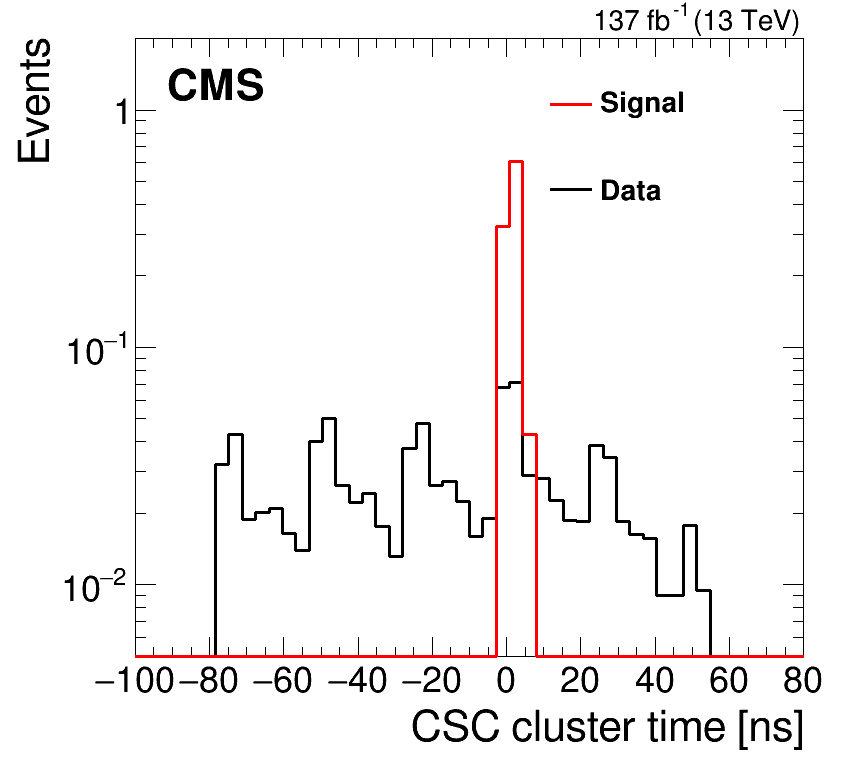

In [40]:
import os
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
# import CMS_lumi, tdrstyle

corrections = 0.90332048232

index = 0

var = [clusterTime]
weights = [weight ]
xaxis = [ 'CSC cluster time [ns]']


name = ['time']
binning = [[50,-100,80]]


leg = rt.TLegend(0.64,0.70,0.92,0.92)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 850, 800)
rt.gStyle.SetOptFit(1011)
h = {}

# plot signal
for i, m in enumerate(masses):
    array = []
    weight_temp = []
    for p in prod:
        k = 'MC_'+p + '_'+m+'_'+str(ct)
        
        array += list(var[index][k].flatten())
        weight_temp += list(0.01*weights[index][k].flatten())
    h[m] = create_TH1D(array, axis_title=[xaxis[index], 'Events'], binning = binning[index], weights = weight_temp)
    h[m].SetLineColor(2)
#     h[m].SetLineStyle(line_style[i])

#     h[m].Scale(corrections)    

#     leg.AddEntry(h[m],"m_{S} = "+m+" GeV",'L')
    leg.AddEntry(h[m],"Signal",'L')


# plot observation

h['data'] = create_TH1D(var[index]['data'].flatten(),  axis_title=[xaxis[index], 'Events'], binning = binning[index])






h['data'].SetLineWidth(3)


h['data'].SetLineColor(1)
h['data'].SetMarkerStyle(20)
h['data'].SetMarkerSize(1.5)
h['data'].GetXaxis().SetTitleOffset(0.99)


leg.AddEntry(h['data'], 'Data','L')
h['data'].Scale(1./h['data'].Integral())
h['data'].GetYaxis().SetRangeUser(0.005,2)
h['data'].Draw('hist')







for k in masses:
    h[k].SetLineWidth(3)
    h[k].Scale(1./h[k].Integral())
    h[k].Draw(' hist same')



latex = rt.TLatex()
latex.SetTextSize(0.05)
latex.SetTextFont(42)

# latex = rt.TLatex()
# latex.SetTextSize(0.04)
# x = 30
# if decay == 'dddd': latex.DrawLatex(x,0.35,  "S #rightarrow d#bar{d}")
# elif decay == 'bbbb': latex.DrawLatex(x,0.35, "S #rightarrow b#bar{b}")
# elif decay == '4Tau': latex.DrawLatex(x,0.35, "S #rightarrow #tau^{+}#tau^{-}")
# latex.DrawLatex(x,0.3, "c#tau = 1 m")



        
# l.SetLineWidth(2)
# l.Draw()    


c.SetRightMargin(0.05)
c.SetBottomMargin(0.15)



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
CMS_lumi.writeExtraText = 0
CMS_lumi.extraText   = "Preliminary"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.12
CMS_lumi.relPosY = 0.05
CMS_lumi.cmsTextSize      = 1.2


CMS_lumi.CMS_lumi(c, 4, 11)

c.SetLogy()
leg.Draw()
c.Draw()
leg.Draw()
outDir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/combination_paper/strategy_csc/'+analyzer_version
if not os.path.isdir(outDir):os.makedirs(outDir)

if CMS_lumi.writeExtraText:
    c.SaveAs(outDir+'/clusterTime_'+decay+'_pas.png')
    c.SaveAs(outDir+'/clusterTime_'+decay+'_pas.C')
    c.SaveAs(outDir+'/clusterTime_'+decay+'_pas.pdf')

else:
    c.SaveAs(outDir+'/clusterTime_'+decay+'_paper.png')
    c.SaveAs(outDir+'/clusterTime_'+decay+'_paper.C')
    c.SaveAs(outDir+'/clusterTime_'+decay+'_paper.pdf')